# Visualize Geneset Coverage

**Gregory Way, 2019**

Visualize the percent coverage of various geneset networks across different datasets.

Each compressed feature is assigned a single geneset based on the greatest enriched geneset by absolute value.
The ensemble models represent the aggregation of genesets across all five iterations per k dimension.
The "all" models represent each compression algorithm combined across all iterations per k dimension.

There are three sets of plots visualized for each coverage analysis.

1. Individual models by algorithm
2. Ensemble models by algorithm (note the difference in y axis)
  * The size of the point represents the relative strength of average enrichment
3. All models (note that coverage is on the right y axis)
  * The bars represent the number of unique genesets contributed by the specific algorithm

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

In [2]:
count_gmt <- function(gmt_name) {
    # Count the number of genesets in a collection
    xcell_file <- file.path("..", "3.build-hetnets", "data", gmt_name)

    con <- file(xcell_file, open = "r")

    genesets <- c()
    while (length(geneset <- readLines(con, n = 1, warn = FALSE)) > 0) {
      geneset <- unlist(strsplit(geneset, "\t"))[1]
      genesets <- unique(c(geneset, genesets))
    }
    close(con)
    return(length(genesets))
}

In [3]:
# Set ggplot theme
coverage_theme <- theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, size = 3.5),
        axis.text.y = element_text(size = 6),
        axis.title = element_text(size = 7),
        plot.title = element_text(hjust = 0.5, size = 8),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 8),
        legend.key.size = unit(1, "lines"))

# Load Constants
algorithm_plot_labels <- c("pca" = "PCA",
                           "ica" = "ICA",
                           "nmf" = "NMF",
                           "dae" = "DAE",
                           "vae" = "VAE")
algorithm_colors <- c("#e41a1c",
                      "#377eb8",
                      "#4daf4a",
                      "#984ea3",
                      "#ff7f00")
algorithms <- names(algorithm_plot_labels)

plot_info_list <- list(
    c("TCGA", "GpH"),
    c("TCGA", "GpXCELL"),
    c("TCGA", "GpC4CM"),
    c("TCGA", "GpC2CPREACTOME"),
    c("TCGA", "GpC3TFT"),
    c("TARGET", "GpH"),
    c("TARGET", "GpXCELL"),
    c("TARGET", "GpC4CM"),
    c("GTEX", "GpXCELL")
)

gmt_file_list = list(
    "gpc1" = "c1.all.v6.1.entrez.gmt",
    "gpc2cpg" = "c2.cgp.v6.1.entrez.gmt",
    "gpc2cpreactome" = "c2.cp.reactome.v6.1.entrez.gmt",
    "gpc3mir" = "c3.mir.v6.1.entrez.gmt",
    "gpc3tft" = "c3.tft.v6.1.entrez.gmt",
    "gpc4cgn" = "c4.cgn.v6.1.entrez.gmt",
    "gpc4cm" = "c4.cm.v6.1.entrez.gmt",
    "gpc5bp" = "c5.bp.v6.1.entrez.gmt",
    "gpc5cc" = "c5.cc.v6.1.entrez.gmt",
    "gpc5mf" = "c5.mf.v6.1.entrez.gmt",
    "gpc6" = "c6.all.v6.1.entrez.gmt",
    "gpc7" = "c7.all.v6.1.entrez.gmt",
    "gph" = "h.all.v6.1.entrez.gmt",
    "gpxcell" = "xcell_all_entrez.gmt"
)

In [4]:
plot_list <- list()
plot_results <- list()

for (plot_info in plot_info_list) {
    dataset <- plot_info[1]
    metaedge <- plot_info[2]
    
    plot_identifier <- paste0(dataset, metaedge)
    plot_list[[plot_identifier]] <- list()

    # Load the number of genes in the collection
    gmt_name <- gmt_file_list[[tolower(metaedge)]]
    gmt_count <- count_gmt(gmt_name)
    
    # Setup file names
    base_file <- paste0(tolower(dataset), "_", tolower(metaedge), ".tsv")

    model_results <- file.path("results", paste0("model_results_", base_file))
    ensemble_results <- file.path("results", paste0("ensemble_results_", base_file))
    all_results <- file.path("results", paste0("all_results_", base_file))
    top_results <- file.path('results', paste0('top_results_', base_file, '.gz'))

    # Load data
    model_df <- readr::read_tsv(model_results,
                                col_types = readr::cols(
                                    .default = readr::col_integer(),
                                    algorithm = readr::col_character(),
                                    model_type = readr::col_character(),
                                    geneset_coverage = readr::col_double(),
                                    abs_top_z_score = readr::col_double(),
                                    dataset = readr::col_character(),
                                    geneset_name = readr::col_character()
                                )) %>%
        dplyr::mutate(p_val = 2 * pnorm(-abs_top_z_score)) %>%
        dplyr::group_by(z_dim) %>%
        dplyr::mutate(bon_alpha = 0.05 / z_dim) %>%
        dplyr::ungroup() %>%
        dplyr::mutate(is_bon_filtered = bon_alpha < p_val) %>%
        dplyr::filter(!is_bon_filtered)

    model_df$algorithm <- factor(model_df$algorithm, levels = algorithms)
    model_df$z_dim <-
      factor(model_df$z_dim,
             levels = sort(as.numeric(paste(unique(model_df$z_dim)))))

    ensemble_df <- readr::read_tsv(ensemble_results,
                                   col_types = readr::cols(
                                       .default = readr::col_integer(),
                                       algorithm = readr::col_character(),
                                       model_type = readr::col_character(),
                                       geneset_coverage = readr::col_double(),
                                       abs_top_z_score = readr::col_double(),
                                       dataset = readr::col_character(),
                                       geneset_name = readr::col_character()
                                    )) %>%
        dplyr::mutate(p_val = 2 * pnorm(-abs_top_z_score)) %>%
        dplyr::group_by(z_dim) %>%
        dplyr::mutate(bon_alpha = 0.05 / z_dim) %>%
        dplyr::ungroup() %>%
        dplyr::mutate(is_bon_filtered = bon_alpha < p_val) %>%
        dplyr::filter(!is_bon_filtered)

    ensemble_df$algorithm <- factor(ensemble_df$algorithm, levels = algorithms)
    ensemble_df$z_dim <-
      factor(ensemble_df$z_dim,
             levels = sort(as.numeric(paste(unique(ensemble_df$z_dim)))))

    ensemble_df$abs_top_z_score[is.infinite(ensemble_df$abs_top_z_score)] <-
        max(ensemble_df$abs_top_z_score[is.finite(ensemble_df$abs_top_z_score)])
    
    all_df <- readr::read_tsv(all_results,
                              col_types = readr::cols(
                                  .default = readr::col_integer(),
                                  model_type = readr::col_character(),
                                  geneset_coverage = readr::col_double(),
                                  abs_top_z_score = readr::col_double(),
                                  dataset = readr::col_character(),
                                  geneset_name = readr::col_character()
                              )) %>%
        dplyr::mutate(p_val = 2 * pnorm(-abs_top_z_score)) %>%
        dplyr::group_by(z_dim) %>%
        dplyr::mutate(bon_alpha = 0.05 / z_dim) %>%
        dplyr::ungroup() %>%
        dplyr::mutate(is_bon_filtered = bon_alpha < p_val) %>%
        dplyr::filter(!is_bon_filtered)

    all_df$z_dim <- factor(all_df$z_dim,
                           levels = sort(as.numeric(paste(unique(all_df$z_dim)))))
    
    top_results_df <- readr::read_tsv(top_results,
                                      col_types = readr::cols(
                                          .default = readr::col_integer(),
                                          algorithm = readr::col_character(),
                                          model_type = readr::col_character(),
                                          top_z_score = readr::col_double(),
                                          geneset = readr::col_character(),
                                          abs_top_z_score = readr::col_double(),
                                          dataset = readr::col_character(),
                                          geneset_name = readr::col_character()
                                      ))

    top_results_df$algorithm <- factor(top_results_df$algorithm, levels = algorithms)
    top_results_df$z_dim <-
      factor(top_results_df$z_dim,
             levels = sort(as.numeric(paste(unique(ensemble_df$z_dim)))))
    
    # Create a new dataframe to display all models
    unique_results_df <- top_results_df %>%
        dplyr::group_by(z_dim) %>%
        dplyr::filter(!(duplicated(geneset) | duplicated(geneset, fromLast = TRUE))) %>%
        dplyr::group_by(algorithm, z_dim) %>%
        dplyr::summarize(number_unique = dplyr::n_distinct(geneset))
    
    unique_results_df <- all_df %>% dplyr::full_join(unique_results_df, by = 'z_dim')
    
    # Generate Plots
    plot_list[[plot_identifier]][['model_gg']] <-
        ggplot(model_df, aes(x = z_dim,
                             y = geneset_coverage * 100)) +
            geom_boxplot(aes(color = algorithm),
                         outlier.size = 0.15,
                         lwd = 0.23) +
            coverage_theme +
            scale_color_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels) +
            xlab("k Dimension") +
            ylab("Coverage (%)") +
            ggtitle("Individual Models")

    plot_list[[plot_identifier]][['ensemble_gg']] <-
        ggplot(ensemble_df, aes(x = z_dim,
                                y = geneset_coverage * 100)) +
            geom_point(aes(color = algorithm,
                           size = log10(abs_top_z_score)),
                       alpha = 0.25) +
            geom_point(aes(color = algorithm),
                       size = 0.15) +
            coverage_theme +
            scale_color_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels) +
            xlab("k Dimension") +
            ylab("Coverage (%)") +
            ggtitle("Ensemble Models")
    
    all_k_coverage <- length(unique(top_results_df$geneset)) / gmt_count * 100
    
    plot_list[[plot_identifier]][['all_gg']] <-
        ggplot(data = unique_results_df) +
            geom_bar(mapping = aes(x = z_dim,
                                   y = number_unique,
                                   fill = algorithm),
                     alpha = 0.5,
                     position = 'stack',
                     stat = 'identity') +
            geom_hline(yintercept = all_k_coverage,
                       color = 'navy',
                       linetype = 'dashed',
                       size = 0.4) +
            coverage_theme +
            xlab("k Dimension") +
            ggtitle("All Models") +
            scale_fill_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels)
    
    # Add specific scale to certain plots
    if (metaedge != "GpH") {
    plot_list[[plot_identifier]][['all_gg']] <-
        plot_list[[plot_identifier]][['all_gg']] +
            geom_point(data = unique_results_df,
                       mapping = aes(x = z_dim,
                                     y = geneset_coverage * 100),
                       size = 0.5) +
            scale_y_continuous(name = 'Unique Genesets',
                               sec.axis = sec_axis(trans = ~./1,
                                                   name = "Coverage (%)"),
                               limits = c(0, 100))
    }
    
    # Track the total coverage of all models across all k dimensions
    plot_results[[plot_identifier]] <- c(dataset, metaedge, all_k_coverage)
    
}

In [5]:
all_k_results_table <- t(dplyr::bind_rows(plot_results))
colnames(all_k_results_table) <- c("Dataset", "Metaedge", "BioBombe_Coverage")
rownames(all_k_results_table) <- 1:nrow(all_k_results_table)

out_file <- file.path("biobombe_coverage_results.tsv")
readr::write_tsv(as.data.frame(all_k_results_table), out_file)

all_k_results_table

,Dataset,Metaedge,BioBombe_Coverage
1,TCGA,GpH,100
2,TCGA,GpXCELL,89.7750511247444
3,TCGA,GpC4CM,96.0556844547564
4,TCGA,GpC2CPREACTOME,91.839762611276
5,TCGA,GpC3TFT,97.2357723577236
6,TARGET,GpH,100
7,TARGET,GpXCELL,93.2515337423313
8,TARGET,GpC4CM,90.7192575406033
9,GTEX,GpXCELL,91.6155419222904


## Generate Supplemental Figure

Plotting xCell Cell Types and MSigDB Hallmark Collection

In [6]:
legend <- get_legend(plot_list[['TCGAGpXCELL']][['all_gg']] +
                     theme(legend.position = "bottom"))

tcga_x_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(xCell Cell Types)',
                        size = 8,
                        angle = 90)
gtex_x_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'GTEx\n(xCell Cell Types)',
                        size = 8,
                        angle = 90)
target_x_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TARGET\n(xCell Cell Types)',
                        size= 8,
                        angle = 90)
tcga_h_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(Hallmarks)',
                        size = 8,
                        angle = 90)
target_h_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TARGET\n(Hallmarks)',
                        size = 8,
                        angle = 90)
label_sup <- cowplot::plot_grid(tcga_x_label,
                                gtex_x_label,
                                target_x_label,
                                tcga_h_label,
                                target_h_label,
                                nrow = 5)

sup_plot <- (
    cowplot::plot_grid(
        plot_list[["TCGAGpXCELL"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpXCELL']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpXCELL']][['all_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[["GTEXGpXCELL"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['GTEXGpXCELL']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['GTEXGpXCELL']][['all_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[["TARGETGpXCELL"]][['model_gg']] +
            theme(legend.position = "none") +
            xlab("") +
            ggtitle(""),
        plot_list[['TARGETGpXCELL']][['ensemble_gg']] +
            theme(legend.position = "none") +
            xlab("") +
            ggtitle(""),
        plot_list[['TARGETGpXCELL']][['all_gg']] +
            theme(legend.position = "none") +
            xlab("") +
            ggtitle(""),
        plot_list[["TCGAGpH"]][['model_gg']] +
            xlab('') +
            ggtitle("") +
            theme(legend.position = "none"),
        plot_list[['TCGAGpH']][['ensemble_gg']] +
            xlab('') +
            ggtitle("") +
            theme(legend.position = "none"),
        plot_list[['TCGAGpH']][['all_gg']] +
            xlab('') +
            ggtitle("") +
            geom_point(mapping = aes(x = z_dim,
                                     y = geneset_coverage * 8),
                       size = 0.5) +
            scale_y_continuous(name = 'Unique Genesets',
                               sec.axis = sec_axis(trans = ~.*12.5,
                                                   name = "Coverage (%)"),
                               limits = c(0, 8)) +
            theme(legend.position = "none"),
        plot_list[["TARGETGpH"]][['model_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TARGETGpH']][['ensemble_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TARGETGpH']][['all_gg']] +
            geom_point(mapping = aes(x = z_dim,
                                     y = geneset_coverage * 8),
                       size = 0.5) +
            scale_y_continuous(name = 'Unique Genesets',
                               sec.axis = sec_axis(trans = ~.*12.5,
                                                   name = "Coverage (%)"),
                               limits = c(0, 8)) +
            ggtitle("") +
            theme(legend.position = "none"),
        labels = c("a", "", "", "b", "", "", "c", "", "", "d", "", "", "e"),
        ncol = 3,
        nrow = 5
    )
)

sup_plot <- cowplot::plot_grid(label_sup,
                               sup_plot,
                               ncol = 2,
                               rel_widths = c(0.04, 1))

sup_plot <- cowplot::plot_grid(sup_plot,
                               legend,
                               rel_heights = c(1, 0.08),
                               nrow = 2)

Warning message:
“Removed 6 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_hline).”Warning message:
“Removed 6 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_hline).”

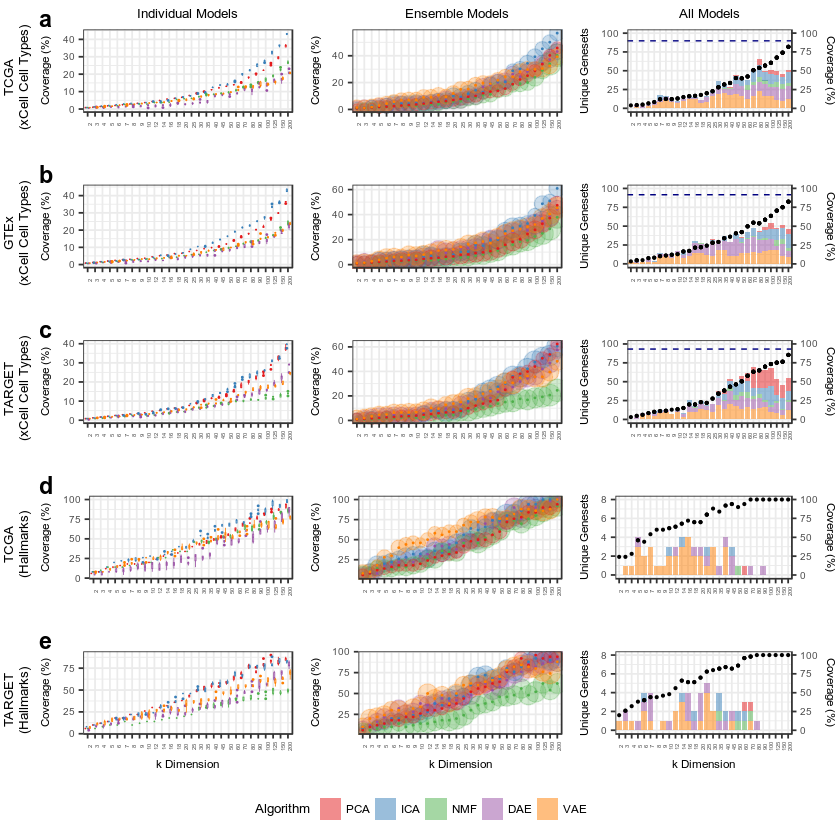

In [7]:
sup_plot

In [8]:
for(extension in c('.png', '.pdf')) {
    fig_file <- paste0("supplemental_coverage", extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = sup_plot,
                       base_height = 200,
                       base_width = 170,
                       units = "mm")
}

## Create Main Figure

In [9]:
legend <- get_legend(plot_list[['TCGAGpC2CPREACTOME']][['all_gg']] +
                     theme(legend.position = "bottom"))

tcga_tf_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(TF Targets)',
                        size= 8,
                        angle = 90)
tcga_react_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(REACTOME)',
                        size = 8,
                        angle = 90)
tcga_cm_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(Cancer Modules)',
                        size = 8,
                        angle = 90)

label_main <- cowplot::plot_grid(tcga_tf_label,
                                 tcga_cm_label,
                                 tcga_react_label,
                                 nrow = 3)

main_plot <- (
    cowplot::plot_grid(
        plot_list[["TCGAGpC3TFT"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpC3TFT']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpC3TFT']][['all_gg']] +
             xlab('') +
            theme(legend.position = "none"),
        plot_list[["TCGAGpC2CPREACTOME"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC2CPREACTOME']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC2CPREACTOME']][['all_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[["TCGAGpC4CM"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC4CM']][['ensemble_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC4CM']][['all_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        labels = c("a", "", "", "b", "", "", "c", "", ""),
        ncol = 3,
        nrow = 3
    )
)

main_plot <- cowplot::plot_grid(label_main,
                                main_plot,
                                ncol = 2,
                                rel_widths = c(0.04, 1))

main_plot <- cowplot::plot_grid(main_plot,
                                legend,
                                rel_heights = c(1, 0.08),
                                nrow = 2)

Warning message:
“Removed 1 rows containing missing values (position_stack).”

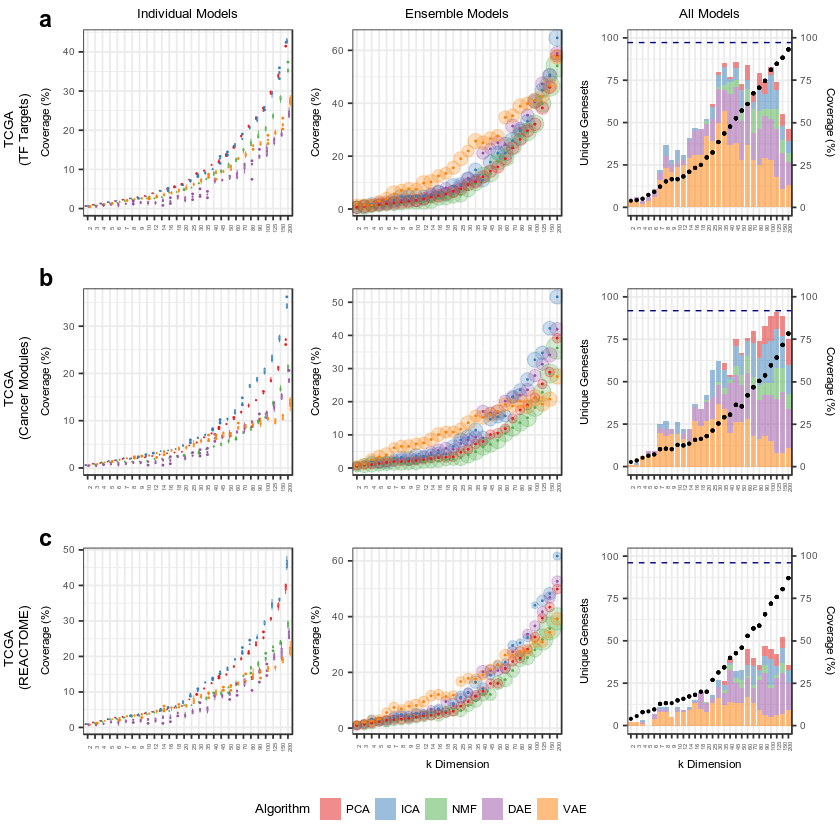

In [10]:
main_plot

In [11]:
for(extension in c('.png', '.pdf')) {
    fig_file <- paste0("main_coverage", extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = main_plot,
                       base_height = 150,
                       base_width = 170,
                       units = "mm")
}